## Vehicle Detection Project
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Loading Dependencies

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

### Defining helper functions for this project

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec,
                                  block_norm="L1")
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec, 
                       block_norm="L1")
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
def color_hist(img, nbins=16, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to convert the color space of an image
def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)

    return feature_image

# Define a function to extract features from a list of images
# Have this function call get_hog_features(), bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=16, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    counter_index = 0
    full_progress = len(imgs)
    
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        feature_image = convert_color(image, color_space)
        if counter_index % 900 == 0:
            progress = int((counter_index/full_progress)*100)
            print(progress, "%")

        if spatial_feat == True:
            # Apply bin_spatial()
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        
        counter_index += 1
    # Return list of feature vectors
    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
 
def apply_threshold(heatmap, threshold):
    heat_thresh = np.copy(heatmap)
    # Zero out pixels below the threshold
    heat_thresh[heatmap <= threshold] = 0
    # Return thresholded map
    return heat_thresh


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

def remove_false_positives(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        if (bbox[1][0]-bbox[0][0]+1)*(bbox[1][1]-bbox[0][1]+1) > 4000 and (bbox[1][0]-bbox[0][0]+1)*(bbox[1][1]-bbox[0][1]+1) < 40000:
            bboxes.append(bbox)
    # Return the bounding bounding boses
    return bboxes

def img_comparison_plot(img_before, sTitleBefore, img_after, sTitleAfter, 
                        mapping_option = None, first_mapping = None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 10))
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    if first_mapping is not None:
        ax1.imshow(img_before, cmap = first_mapping)
    else:
        ax1.imshow(img_before)
    ax1.set_title(sTitleBefore, fontsize = 24)
    
    if mapping_option is not None:
        ax2.imshow(img_after, cmap = mapping_option)
    else:
        ax2.imshow(img_after)
    ax2.set_title(sTitleAfter, fontsize = 24)
    plt.show()

### 1. Data Aquisition

In [3]:
car_images = glob.glob('../../Assets/data/vehicles/**/*.png')
noncar_images = glob.glob('../../Assets/data/non-vehicles/**/*.png')

# Confirming data has been successfuly loaded
print(len(car_images), len(noncar_images))

8792 8968


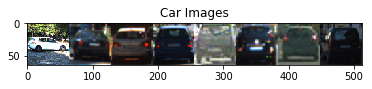

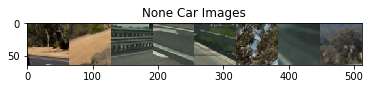

In [4]:
def get_img(path):
    return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

def plot_rand_selected_imgs(input_images, sTitle, num_plot = 8):
    imgs2plot = []
    
    for i in range(num_plot):
        img = cv2.imread(input_images[np.random.randint(0,len(input_images))])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        imgs2plot.append(img)
    imgs2plot = np.concatenate(imgs2plot, axis = 1)
    
    plt.imshow(imgs2plot)
    plt.title(sTitle)
    plt.show()
    

plot_rand_selected_imgs(car_images, "Car Images")
plot_rand_selected_imgs(noncar_images, "None Car Images")

### 2. HOG extraction

#### 2.1 Examples on Histogram of Oriented Gradients visualization

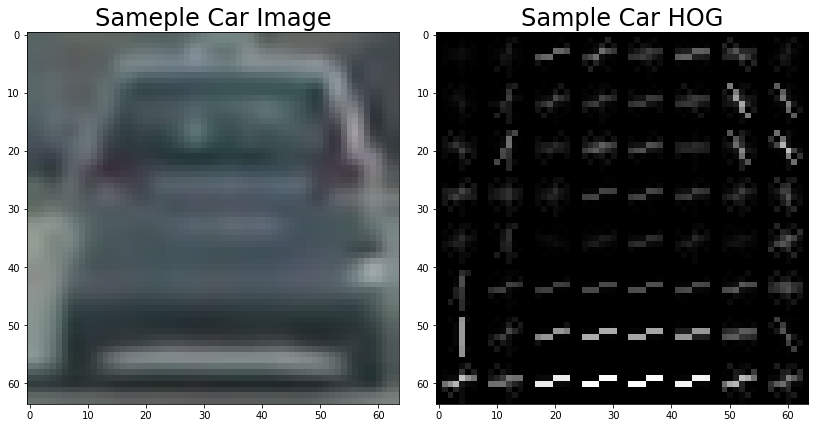

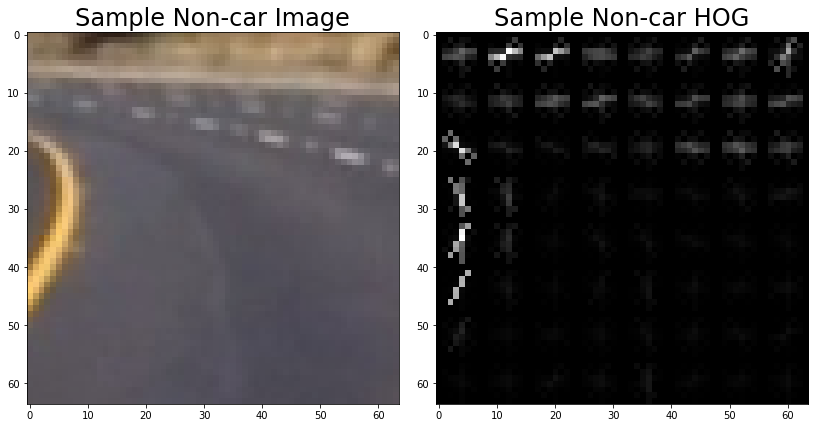

In [5]:
car_img = mpimg.imread(car_images[3])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[3])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

img_comparison_plot(car_img, 'Sameple Car Image', 
                    car_dst, 'Sample Car HOG', 
                    mapping_option = 'gray')

img_comparison_plot(noncar_img, 'Sample Non-car Image', 
                    noncar_dst, 'Sample Non-car HOG', 
                    mapping_option = 'gray')

#### 2.2 Classifier object definition

In [7]:
class CAR_CLASSIFIER():
    def __init__(self, dataset):
        self.color_space = 'YUV'
        self.spatial_size = (16, 16)
        self.hist_bins = 16
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 0
        self.spatial_feat = True
        self.hist_feat = True
        self.hog_feat = True
        
        self.car_data = dataset['car_data']
        self.non_car_data = dataset['non_car_data']
        
        self.car_features = None
        self.non_car_features = None
        
        self.cells_per_step = 1
        self.all_heats      = []
        self.window         = 64
        self.heat_thresh    = 3
        self.scales         = [1, 1.5, 2, 2.5, 3]
        self.y_start_stops  = [[380, 492], [380, 548], [380, 604], [380, 680], [350, 700]]

    def extract_data_features(self, oSettings):
        t=time.time()
        
        self.color_space = oSettings['color_space']
        self.spatial_size = oSettings['spatial_size']
        self.hist_bins = oSettings['hist_bins']
        self.orient = oSettings['orient']
        self.pix_per_cell = oSettings['pix_per_cell']
        self.cell_per_block = oSettings['cell_per_block']
        self.hog_channel = oSettings['hog_channel']

        print("Start feature extraction for cars......")
        self.car_features = extract_features(self.car_data,
                                            color_space = self.color_space,
                                            spatial_size = self.spatial_size,
                                            hist_bins = self.hist_bins, 
                                            orient = self.orient,
                                            pix_per_cell = self.pix_per_cell,
                                            cell_per_block = self.cell_per_block,
                                            hog_channel = self.hog_channel,
                                            spatial_feat = self.spatial_feat,
                                            hist_feat = self.hist_feat,
                                            hog_feat = self.hog_feat)

        print()
        print("Start feature extraction for non-cars......")
        self.non_car_features = extract_features(self.non_car_data,
                                            color_space = self.color_space,
                                            spatial_size = self.spatial_size,
                                            hist_bins = self.hist_bins,
                                            orient = self.orient,
                                            pix_per_cell = self.pix_per_cell,
                                            cell_per_block = self.cell_per_block,
                                            hog_channel = self.hog_channel,
                                            spatial_feat = self.spatial_feat,
                                            hist_feat = self.hist_feat,
                                            hog_feat = self.hog_feat)

        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to extract HOG features...')
        self.X = np.vstack((self.car_features, self.non_car_features)).astype(np.float64)
        
        self.y = np.hstack((np.ones(len(self.car_features)), np.zeros(len(self.non_car_features))))
        print('Feature vectors shape:',self.X.shape)

    def scale_features(self):
        self.X_scaler = StandardScaler().fit(self.X)
        self.scaled_X = self.X_scaler.transform(self.X)

    def data_split(self):
        rand_state = np.random.randint(0, 100)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.scaled_X, self.y, test_size=0.2, random_state=rand_state)

    def train_SVC(self):
        svc = LinearSVC()
        t=time.time()

        svc.fit(self.X_train, self.y_train)

        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')

        self.svc = svc

    def get_accuracy(self):
        print('Test Accuracy of SVC = ', round(self.svc.score(self.X_test, self.y_test), 4))

    def predict(self, img):
        print('SVC predicts: ', self.svc.predict(img))
    
    def predict2(self, X_samples, y_samples):
        pass_count = 0
        for i, img in enumerate(X_samples):
            prediction = self.svc.predict(img)
            if prediction == y_samples[i]:
                pass_count += 1
            print("Prediction: ", prediction, ",  actual: ", y_samples[i])
        
        rate = float(pass_count/len(y_samples))
        print("Prediction correct rate = {:.3f}".format(rate * 100))

    def save_pickle_files(self):
        print('Saving data to pickle file...')
        with open('processed_hog_data.p', 'wb') as pfile:
                pickle.dump({   
                    'svc':self.svc,
                    'car_features': self.car_features,
                    'non_car_features': self.non_car_features,
                    'X_scaler': self.X_scaler,
                    'X_train': self.X_train,
                    'y_train': self.y_train,
                    'X_test': self.X_test,
                    'y_test': self.y_test
                },pfile, pickle.HIGHEST_PROTOCOL)

        print('Data cached in pickle file.')

    def load_data(self):
        with open('processed_hog_data.p', mode = 'rb') as file:
            processed_data = pickle.load(file)
        self.svc = processed_data['svc']
        self.car_features = processed_data['car_features']
        self.non_car_features = processed_data['non_car_features']
        self.X_scaler = processed_data['X_scaler']
        self.X_train = processed_data['X_train']
        self.y_train = processed_data['y_train']
        self.X_test = processed_data['X_test']
        self.y_test = processed_data['y_test']
        print('Data loading complete')
    
    def set_hog_channel(self, option):
        self.hog_channel = option
    
    def set_search_scope(self, aSettings):
        self.scales = []
        self.y_start_stops = []
        for (yStart, yStop, scale) in aSettings:
            self.y_start_stops.append([yStart, yStop])
            self.scales.append(scale)
        print("Done")
    
    # Define a single function that can extract features using hog sub-sampling and make predictions
    def find_cars_rect(self, img, ystart, ystop, scale, cells_per_step = 2, 
                       window = 64, b_shall_all_rect = False):
        rectangles = []

        img = img.astype(np.float32)/255

        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, color_space='YCrCb')
        # rescale image if other than 1.0 scale
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        # select colorspace channel for HOG 
        if self.hog_channel == 'ALL':
            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]
        else: 
            ch1 = ctrans_tosearch[:,:, self.hog_channel]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
        nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 
        nfeat_per_block = self.orient * self.cell_per_block**2


        nblocks_per_window = (window // self.pix_per_cell) - self. cell_per_block + 1

        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * self.pix_per_cell
                ytop = ypos * self.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop : ytop+window, xleft : xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size = self.spatial_size)
                hist_features = color_hist(subimg, nbins = self.hist_bins)

                # Scale features and make a prediction
                test_features = self.X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = self.X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = self.svc.predict(test_features)

                if test_prediction == 1 or b_shall_all_rect:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    rectangles.append(((xbox_left, ytop_draw+ystart),
                                       (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

        return rectangles
    
    def set_sliding_window_param(self, oSettings):
        self.cells_per_step = oSettings['cells_per_step']
        self.window         = oSettings['window']
        
    def find_cars2(self, img, aSettings, bShowAllRectangles = False, color_option = (255,0,0)):
        rects = []
        draw_img = np.copy(img)
        for (ystart, ystop, scale) in aSettings:
            rect = self.find_cars_rect(img, ystart, ystop, scale, 
                                             cells_per_step = self.cells_per_step, 
                                             window = self.window, 
                                             b_shall_all_rect = bShowAllRectangles)
            rects.append(rect)
        rects2draw = [item for sublist in rects for item in sublist] 
        return draw_boxes(draw_img, rects2draw, color = color_option, thick=2) 
            
    def find_cars(self, img):

        draw_img = np.copy(img)
        img = img.astype(np.float32)/255

        rectangles = []

        for y_start_stop, scale in zip(self.y_start_stops, self.scales):

            img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]

            ctrans_tosearch = convert_color(img_tosearch, color_space=self.color_space)

            if scale != 1:
                imshape = ctrans_tosearch.shape
                ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                             (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]

            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // self.pix_per_cell)-1
            nyblocks = (ch1.shape[0] // self.pix_per_cell)-1

            nfeat_per_block = self.orient*self.cell_per_block**2

            # Compute individual channel HOG features for the entire image
            hog1 = get_hog_features(ch1, self.orient,
                    self.pix_per_cell, self.cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, self.orient,
                    self.pix_per_cell, self.cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, self.orient,
                    self.pix_per_cell, self.cell_per_block, feature_vec=False)


            # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
            nblocks_per_window = (self.window // self.pix_per_cell)-1

            nxsteps = (nxblocks - nblocks_per_window) // self.cells_per_step
            nysteps = (nyblocks - nblocks_per_window) // self.cells_per_step

            i = 0

            for xb in range(nxsteps+1):
                for yb in range(nysteps+1):
                    i += 1

                    if xb == (nxsteps + 1):
                        xpos = ch1.shape[1] - nblocks_per_window
                    else:
                        xpos = xb*self.cells_per_step

                    if yb == (nysteps + 1):
                        ypos = ch1.shape[0] - nblocks_per_window
                    else:
                        ypos = yb*self.cells_per_step


                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

                    if self.hog_channel == 'ALL':
                        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                    elif self.hog_channel == '0':
                        hog_features = hog_feat1
                    elif self.hog_channel == '1':
                        hog_features = hog_feat2
                    elif self.hog_channel == '2':
                        hog_features = hog_feat3

                    xleft = xpos*self.pix_per_cell
                    ytop  = ypos*self.pix_per_cell

                    # Extract the image patch
                    subimg = cv2.resize(ctrans_tosearch[ytop:ytop+self.window, xleft:xleft+self.window], (64,64))

                    # Get color features
                    spatial_features = bin_spatial(subimg, size=self.spatial_size)
                    hist_features    = color_hist(subimg, nbins=self.hist_bins)

                    img_features = []

                    if self.spatial_feat:
                        img_features.append(spatial_features)
                    if self.hist_feat:
                        img_features.append(hist_features)
                    if self.hog_feat:
                        img_features.append(hog_features)

                    img_features = np.concatenate(img_features).reshape(1, -1)

                    # Scale features and make a prediction
                    test_features   = self.X_scaler.transform(img_features)
                    test_prediction = self.svc.predict(test_features)

                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(self.window*scale)

                    if test_prediction == 1:
                        rectangles.append(((xbox_left, ytop_draw + y_start_stop[0]),
                            (xbox_left + win_draw, ytop_draw + win_draw + y_start_stop[0])))

        return rectangles
    
    def processing_pipeline(self, image):
        draw_image = np.copy(image)

        # Generate heatmap
        heatmap = np.zeros((image.shape[0], image.shape[1]), np.uint8)

        hot_windows = self.find_cars(image)

        heatmap = add_heat(heatmap, hot_windows)

        # Apply threshold to the heatmap
        heatmap = apply_threshold(heatmap, self.heat_thresh)

        # Apply SciPy labeling
        labels = label(heatmap)

        # draw the bounding box on the image 
        draw_image = np.copy(image)
        draw_image = draw_labeled_bboxes(draw_image, labels)

        return draw_image
    
    def set_heat_thresh(self, value):
        self.heat_thresh = value

#### 2.3 Creating classifier and extracting car and non car features

In [8]:
oClassifier = CAR_CLASSIFIER({
    'car_data': car_images,
    'non_car_data': noncar_images
})

In [9]:
oClassifier.extract_data_features({
    'color_space': 'YUV',
    'spatial_size': (16, 16),
    'hist_bins': 16,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

Start feature extraction for cars......
0 %
10 %
20 %
30 %
40 %
51 %
61 %
71 %
81 %
92 %

Start feature extraction for non-cars......
0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
61.97 Seconds to extract HOG features...
Feature vectors shape: (17760, 6108)


In [10]:
# Feature normalization
oClassifier.scale_features()

# Split into training set and test set
oClassifier.data_split()

In [11]:
# Starts training the classifier
oClassifier.train_SVC()

15.16 Seconds to train SVC...


In [12]:
oClassifier.get_accuracy()

Test Accuracy of SVC =  0.9879


In [13]:
# Save the classifier for later use
# oClassifier.save_pickle_files()

In [13]:
oClassifier = CAR_CLASSIFIER({
    'car_data': car_images,
    'non_car_data': noncar_images
})
oClassifier.load_data()
oClassifier.set_hog_channel('ALL')

Data loading complete


### 3. Sliding window search

#### 3.1 Example on sliding window search

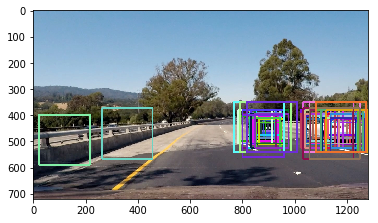

In [13]:
image       = mpimg.imread("./test_images/test4.jpg")
draw_image  = np.copy(image)
hot_windows = oClassifier.find_cars(image)
draw_image  = draw_boxes(draw_image, hot_windows, color='random', thick=6)

plt.imshow(draw_image)
plt.show()

#### 3.2 Sample of  potential search areas

In [7]:
# aScopeSettings = [
#     (380, 492, 1),
#     (380, 548, 1.5),
#     (380, 604, 2),
#     (380, 680, 2.5),
#     (380, 700, 3)
# ]

# oClassifier.set_search_scope(aScopeSettings)

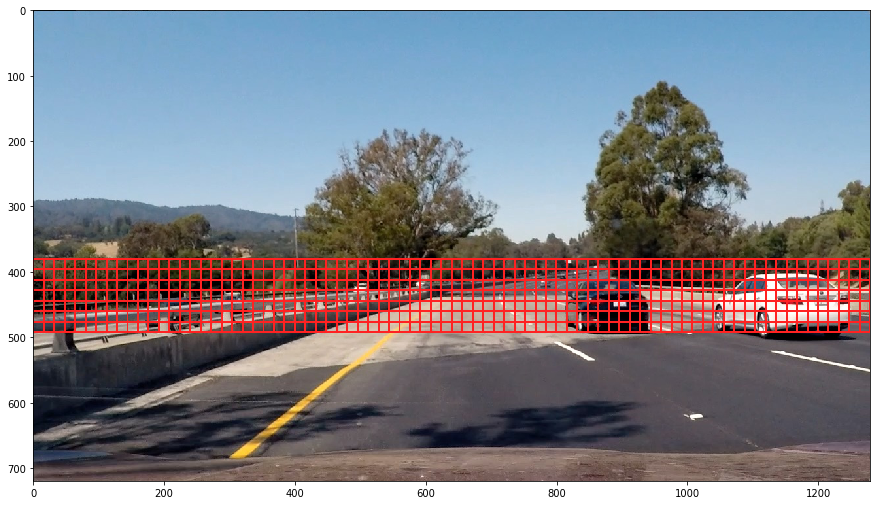

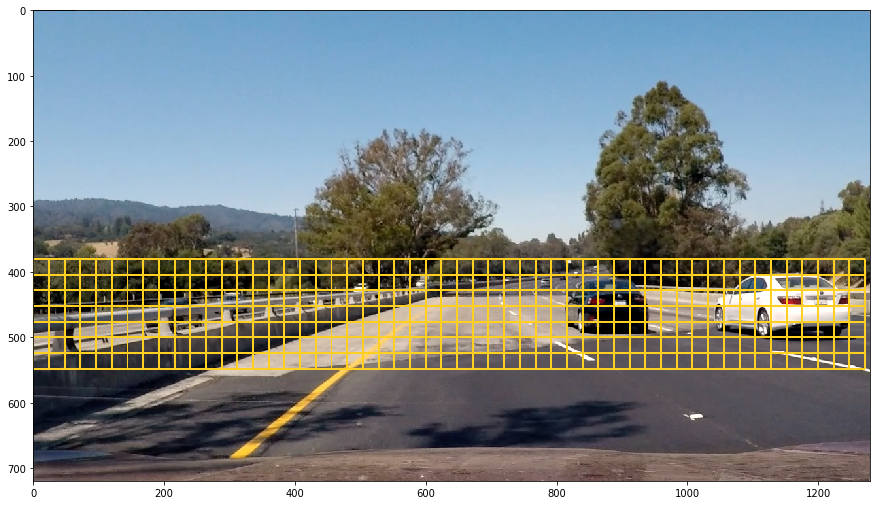

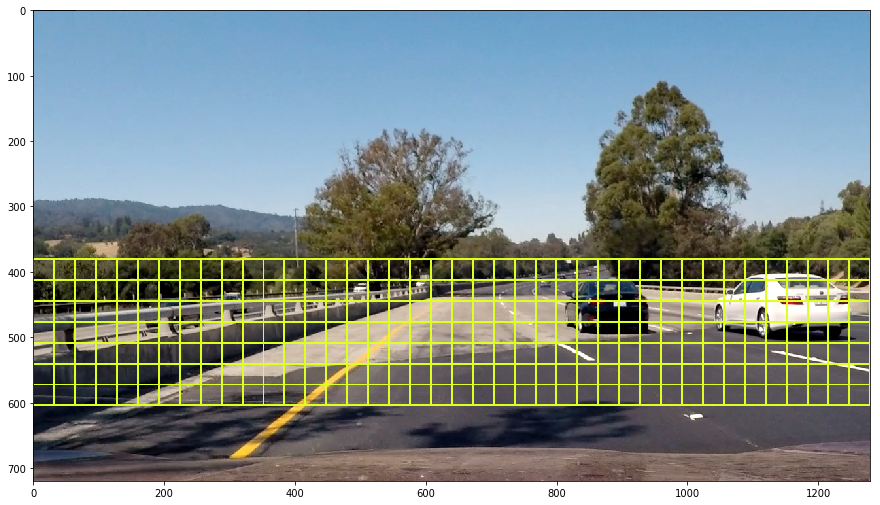

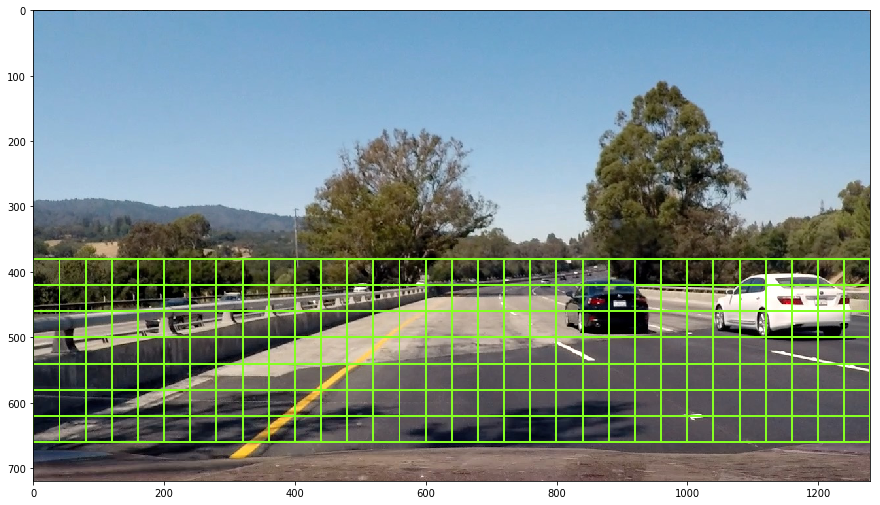

In [14]:
oClassifier.set_sliding_window_param({
    'cells_per_step': 2,
    'window': 64
})
aSettings = [
    (380, 492, 1)
]
rect_draw = oClassifier.find_cars2(image, aSettings, bShowAllRectangles = True, 
                                   color_option = (255, 34, 34))

plt.figure(figsize=(15,10))
plt.imshow(rect_draw)
plt.show()


aSettings = [
    (380, 548, 1.5)
]
rect_draw = oClassifier.find_cars2(image, aSettings, bShowAllRectangles = True, 
                                   color_option = (255, 208, 34))

plt.figure(figsize=(15,10))
plt.imshow(rect_draw)
plt.show()

aSettings = [
    (380, 604, 2)
]
rect_draw = oClassifier.find_cars2(image, aSettings, bShowAllRectangles = True, 
                                   color_option = (221, 255, 34))

plt.figure(figsize=(15,10))
plt.imshow(rect_draw)
plt.show()


aSettings = [
    (380, 680, 2.5)
]
rect_draw = oClassifier.find_cars2(image, aSettings, bShowAllRectangles = True, 
                                   color_option = (134, 255, 34))

plt.figure(figsize=(15,10))
plt.imshow(rect_draw)
plt.show()

#### 3.3 Examples on heatmap generation

##### 3.3a. Generating heatmap base on the detected box superposition

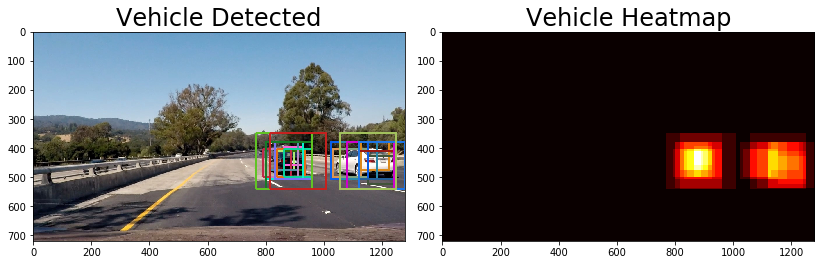

In [15]:
# Load the sample image
image       = mpimg.imread("./test_images/test4.jpg")

# Get a rectangled_drawn image
draw_image  = np.copy(image)
hot_windows = oClassifier.find_cars(image)
draw_image  = draw_boxes(draw_image, hot_windows, color='random', thick=6)

all_heats = []
# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
# Add heat to each box in box list
heat = add_heat(heat, hot_windows)

img_comparison_plot(draw_image, 'Vehicle Detected', 
                    heat, 'Vehicle Heatmap', 
                    mapping_option = 'hot')

##### 3.3b. Apply thresholding to eliminate the false positive

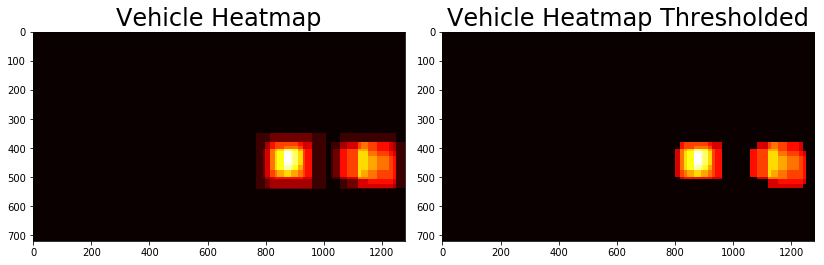

In [16]:
# Apply Threshold on heatmap to elimiate false positive
heat_threshed = apply_threshold(heat, 3)

img_comparison_plot(heat, 'Vehicle Heatmap', 
                    heat_threshed, 'Vehicle Heatmap Thresholded', 
                    mapping_option = 'hot', 
                    first_mapping = 'hot')

##### 3.3c. Apply SciPy labels to heatmap

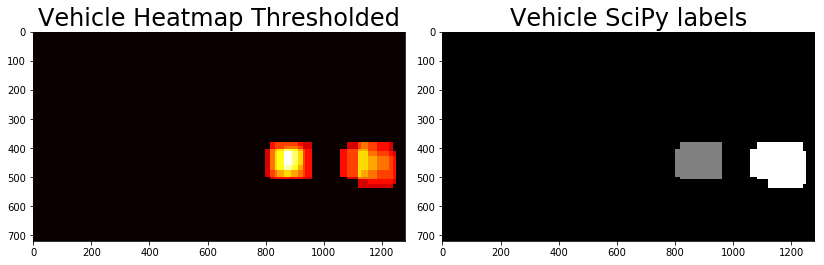

In [17]:
# Apply SciPy labels to heatmap
heat_labels = label(heat_threshed)[0]

img_comparison_plot(heat_threshed, 'Vehicle Heatmap Thresholded', 
                    heat_labels, 'Vehicle SciPy labels', 
                    mapping_option = 'gray', 
                    first_mapping = 'hot')

##### 3.3d More examples

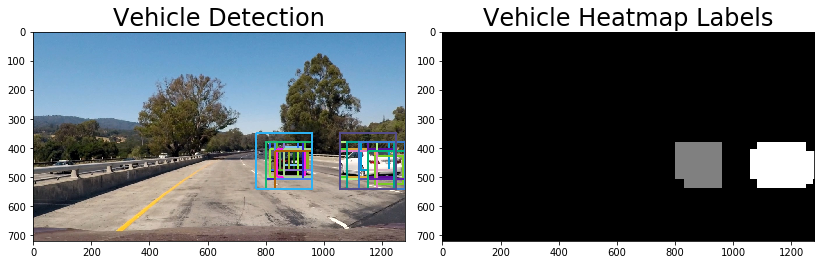

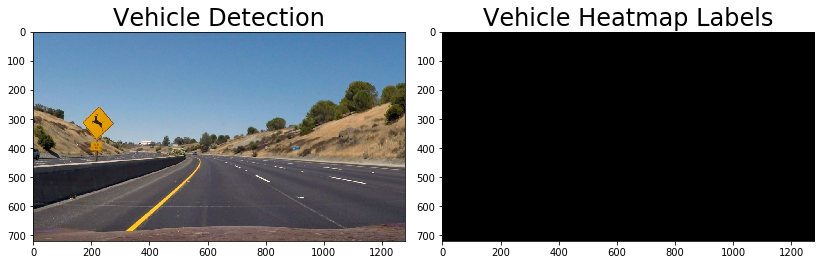

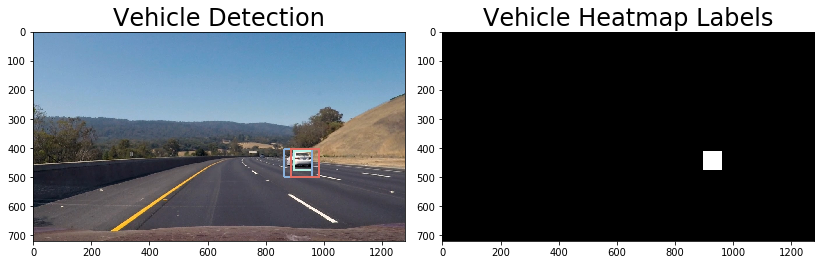

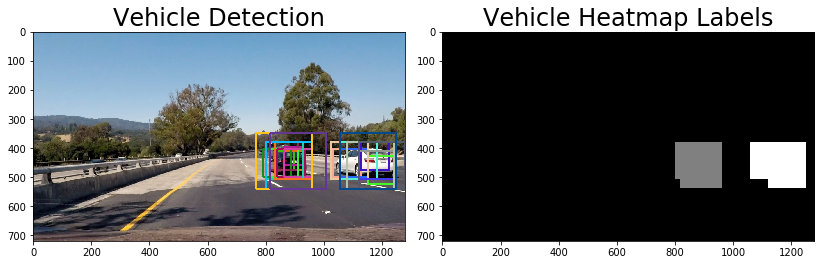

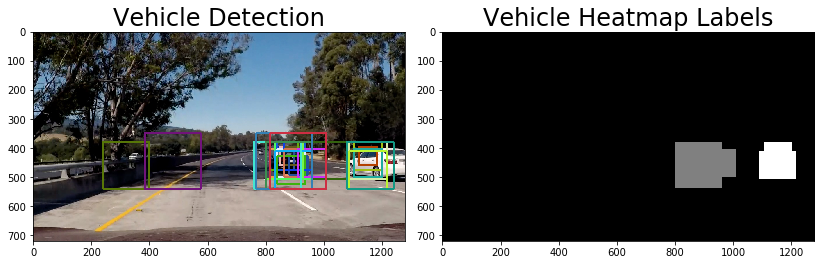

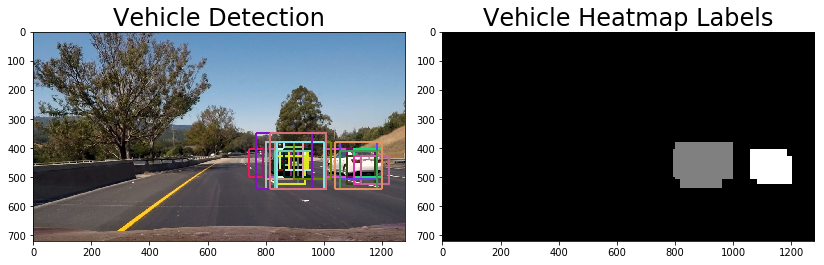

In [18]:
images = glob.glob("./test_images/test*.jpg")

for img_path in images:
    time1 = time.time()
    image = mpimg.imread(img_path)
    
    draw_image  = np.copy(image)
    rect = oClassifier.find_cars(image)
    detection_img  = draw_boxes(image, rect, color='random', thick=6)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, rect)
    heat_thresh = apply_threshold(heat, 2.5)
    heat_labels = label(heat_thresh)[0]
    
    img_comparison_plot(detection_img, 'Vehicle Detection', 
                    heat_labels, 'Vehicle Heatmap Labels', 
                    mapping_option = 'gray')

##### 3.3e Final output

In [20]:
oClassifier.set_heat_thresh(2)

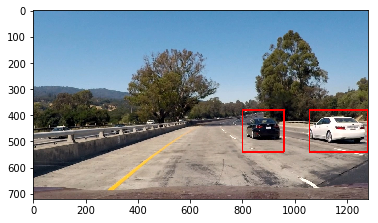

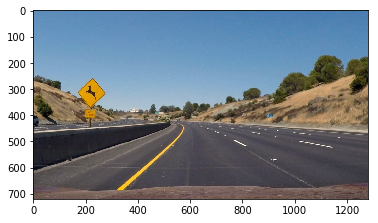

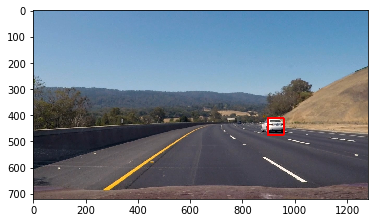

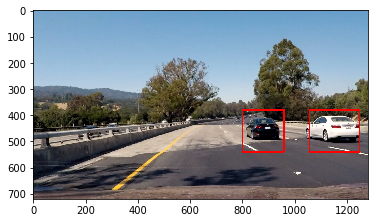

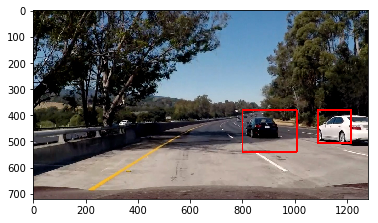

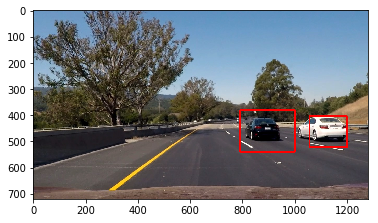

In [21]:
images = glob.glob("./test_images/test*.jpg")

for img_path in images:
    time1 = time.time()
    image = mpimg.imread(img_path)
    
    draw_image = oClassifier.processing_pipeline(image)        
    plt.imshow(draw_image)
    plt.show()

### 4. Processing pipeline for videos

In [36]:
def processing_pipeline(image, fnFindCars, heat_thresh):
    draw_image = np.copy(image)

    # Generate heatmap
    heatmap = np.zeros((image.shape[0], image.shape[1]), np.uint8)

    hot_windows = fnFindCars(image)

    heatmap = add_heat(heatmap, hot_windows)

    # Apply threshold to the heatmap
    heatmap = apply_threshold(heatmap, heat_thresh)

    # Apply SciPy labeling
    labels = label(heatmap)

    # draw the bounding box on the image 
    draw_image = np.copy(image)
    draw_image = draw_labeled_bboxes(draw_image, labels)

    return draw_image

In [22]:
# aScopeSettings = [
#     (380, 492, 1),
#     (380, 548, 1.5),
#     (380, 604, 2),
#     (380, 680, 2.5),
#     (380, 700, 3)
# ]

# oClassifier.set_search_scope(aScopeSettings)
oClassifier.set_heat_thresh(3)

#### 4.1 On test video

In [60]:
output_file = 'test_video_output1.mp4'
input_clip = VideoFileClip("test_video.mp4")
output_clip = input_clip.fl_image(oClassifier.processing_pipeline) 
%time output_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video test_video_output1.mp4
[MoviePy] Writing video test_video_output1.mp4


 97%|████████████████████████████████████████▉ | 38/39 [01:05<00:01,  1.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output1.mp4 

Wall time: 1min 6s


#### 4.2 On project video

In [13]:
output_file = 'project_video_output2.mp4'
input_clip = VideoFileClip("project_video.mp4")
output_clip = input_clip.fl_image(oClassifier.processing_pipeline) 
%time output_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████████████████████████████████▉| 1260/1261 [38:03<00:01,  1.81s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

Wall time: 38min 3s
